In [3]:
import pandas as pd
from transformers import BertModel, BertTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.decomposition import PCA

In [7]:
# Load a pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"  # You can use other models like 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Ensure model is in evaluation mode
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [4]:
df = pd.read_csv('test_data.csv', encoding = "cp1252")

In [8]:
def embed_text(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Pass through BERT model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract the embeddings (we'll use the [CLS] token's embedding as a summary)
    embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings.squeeze().numpy()

In [9]:
df['Purpose_Embedding'] = df['Purpose'].astype(str).apply(embed_text)
df['Description_Embedding'] = df['Description'].astype(str).apply(embed_text)

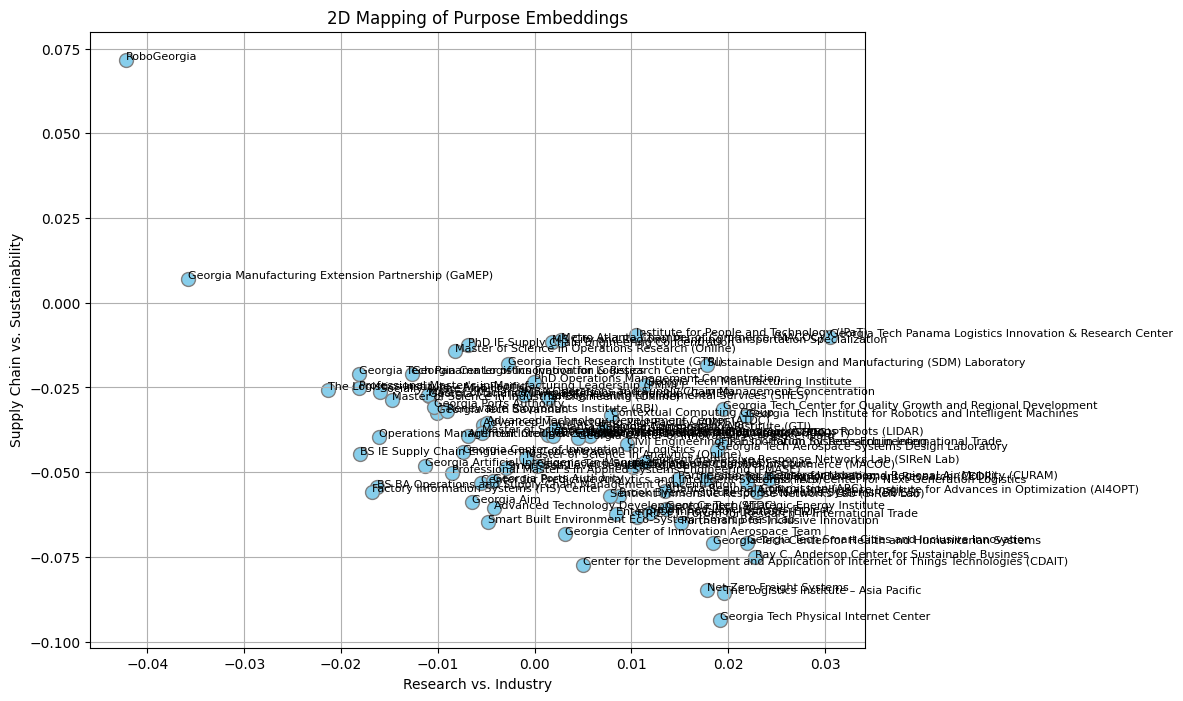

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Define the directional terms and embed them
directions = ["Academic Research", "Industry Application", "supply chain", "sustainability"]
direction_embeddings = [embed_text(direction) for direction in directions]

# Extract the embeddings for easier reference
research_embedding, industry_embedding, supply_chain_embedding, sustainability_embedding = direction_embeddings

# Calculate the X and Y coordinates for each entity based on cosine similarity
x_coords = []
y_coords = []

for purpose_embedding in df['Purpose_Embedding']:
    # X-axis (Research vs. Industry)
    similarity_to_research = cosine_similarity([purpose_embedding], [research_embedding])[0][0]
    similarity_to_industry = cosine_similarity([purpose_embedding], [industry_embedding])[0][0]
    x = similarity_to_research - similarity_to_industry
    
    # Y-axis (Supply Chain vs. Sustainability)
    similarity_to_supply_chain = cosine_similarity([purpose_embedding], [supply_chain_embedding])[0][0]
    similarity_to_sustainability = cosine_similarity([purpose_embedding], [sustainability_embedding])[0][0]
    y = similarity_to_supply_chain - similarity_to_sustainability

    x_coords.append(np.log1p(x))  # Log transformation
    y_coords.append(np.log1p(y))

# Add coordinates to the DataFrame for plotting
df['X'] = x_coords
df['Y'] = y_coords

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['X'], df['Y'], s=100, color='skyblue', edgecolor='gray')
plt.xlabel("Research vs. Industry")
plt.ylabel("Supply Chain vs. Sustainability")
plt.title("2D Mapping of Purpose Embeddings")

# Annotate each point with its entity name for clarity (assuming there's an 'Entity' column)
for i, row in df.iterrows():
    plt.annotate(row['Entity'], (row['X'], row['Y']), fontsize=8)

plt.grid(True)
plt.show()

## Outlier Removal

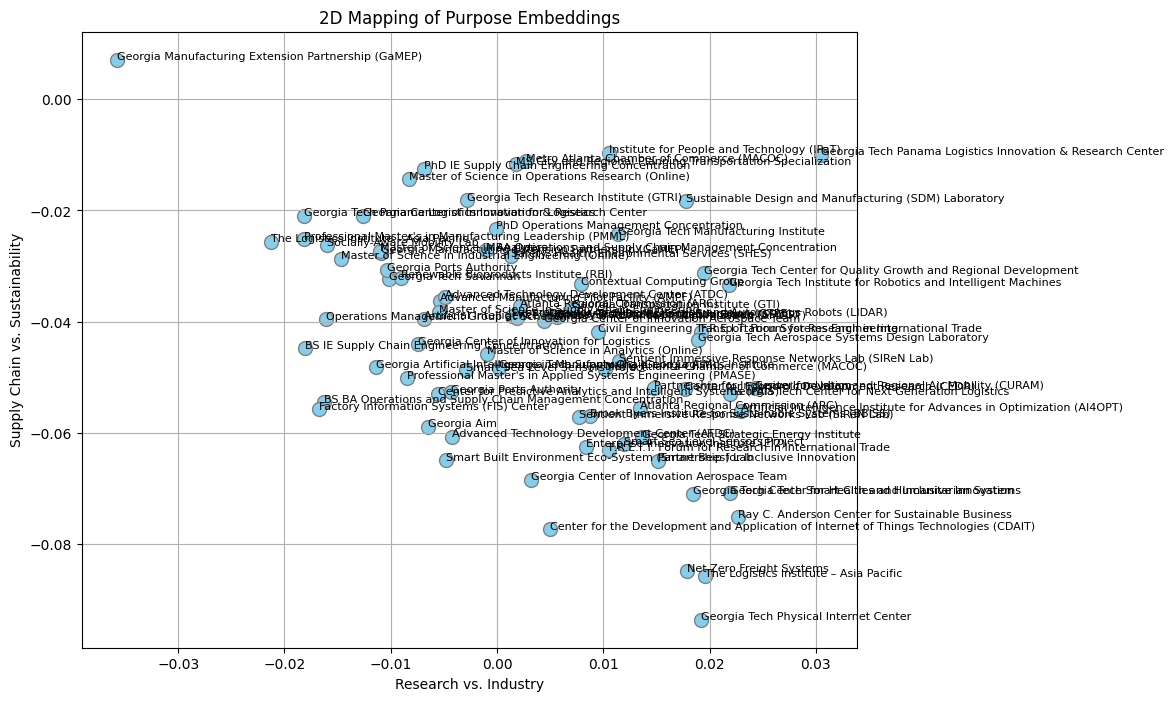

In [17]:
df = df[df['Entity'] != "RoboGeorgia"]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['X'], df['Y'], s=100, color='skyblue', edgecolor='gray')
plt.xlabel("Research vs. Industry")
plt.ylabel("Supply Chain vs. Sustainability")
plt.title("2D Mapping of Purpose Embeddings")

# Annotate each point with its entity name for clarity (assuming there's an 'Entity' column)
for i, row in df.iterrows():
    plt.annotate(row['Entity'], (row['X'], row['Y']), fontsize=8)

plt.grid(True)
plt.show()

## Add "Georgia Tech"ness as a 3rd dimension

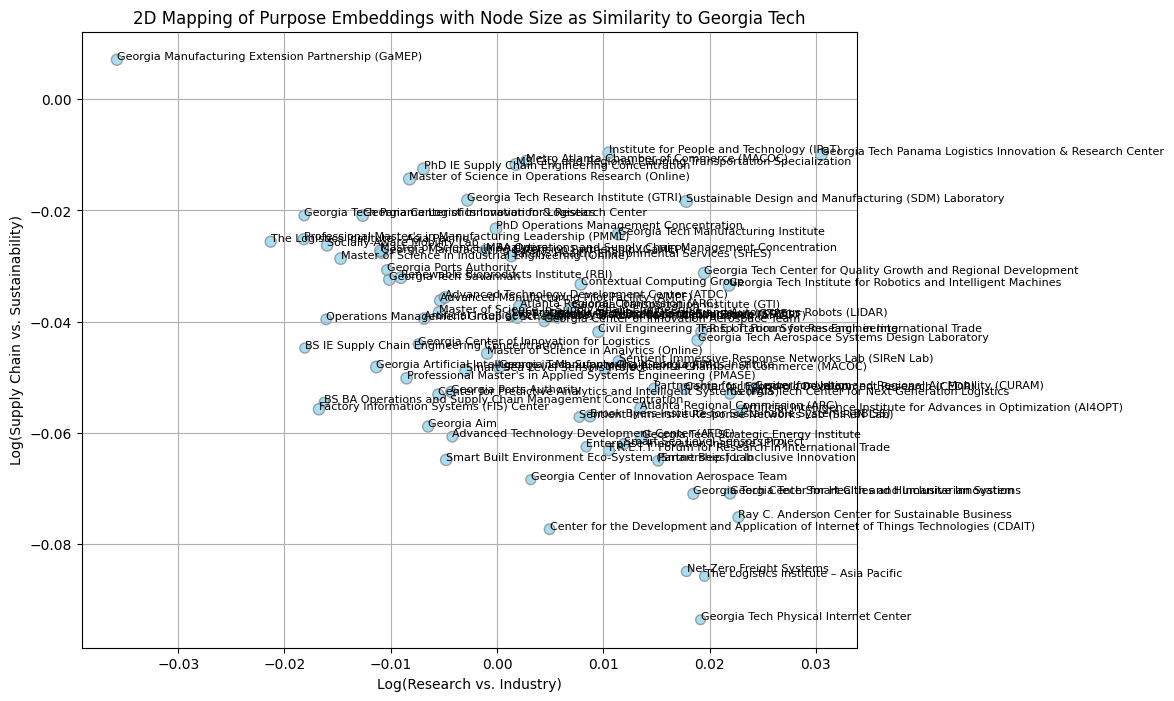

In [19]:
# Get the embedding for "Georgia Tech"
georgia_tech_embedding = embed_text("Georgia Tech")

# Calculate radius based on similarity to "Georgia Tech"
radii = []

for purpose_embedding in df['Purpose_Embedding']:
    # Compute cosine similarity to "Georgia Tech"
    similarity_to_georgia_tech = cosine_similarity([purpose_embedding], [georgia_tech_embedding])[0][0]
    # Set the radius based on similarity
    radius = similarity_to_georgia_tech * 100  # Scale up for better visualization
    radii.append(radius)

# Add the radius as a new column to the DataFrame
df['Radius'] = radii

# Plot the results with the radius as the size of each point
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['X'], df['Y'], s=df['Radius'], color='skyblue', edgecolor='gray', alpha=0.7)
plt.xlabel("Log(Research vs. Industry)")
plt.ylabel("Log(Supply Chain vs. Sustainability)")
plt.title("2D Mapping of Purpose Embeddings with Node Size as Similarity to Georgia Tech")

# Annotate each point with its entity name
for i, row in df.iterrows():
    plt.annotate(row['Entity'], (row['X'], row['Y']), fontsize=8)

plt.grid(True)
plt.show()

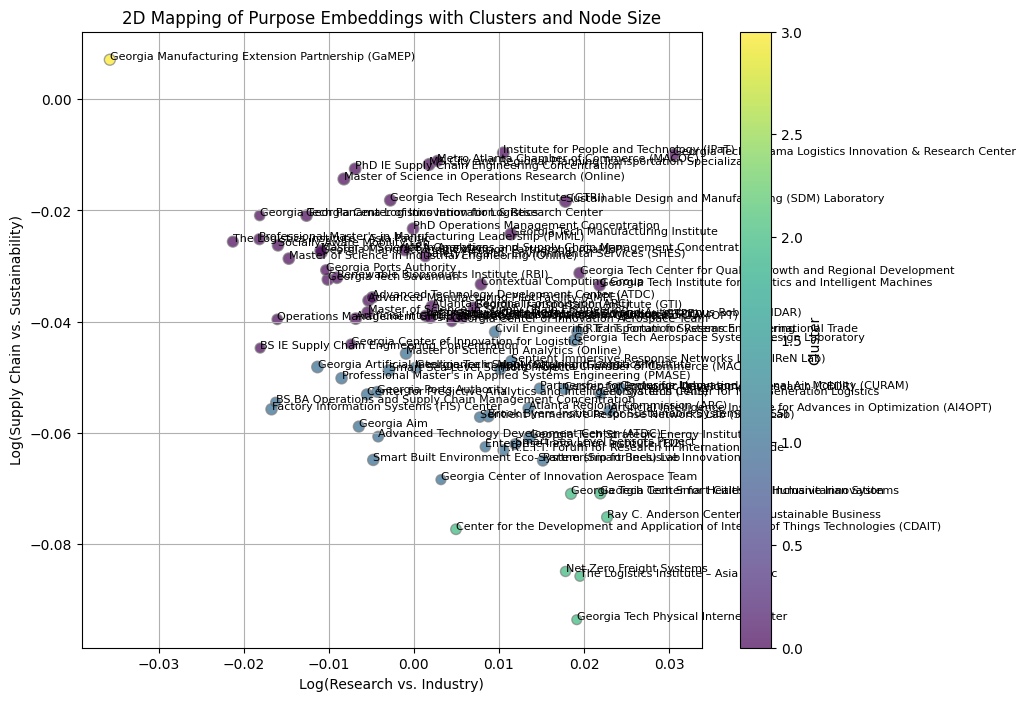

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply KMeans clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=0)
df['Cluster'] = kmeans.fit_predict(df[['X', 'Y']])

# Plot the clusters with radius-based node sizes
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['X'], df['Y'], s=df['Radius'], c=df['Cluster'], cmap='viridis', edgecolor='gray', alpha=0.7)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("Log(Research vs. Industry)")
plt.ylabel("Log(Supply Chain vs. Sustainability)")
plt.title("2D Mapping of Purpose Embeddings with Clusters and Node Size")

# Annotate each point with its entity name
for i, row in df.iterrows():
    plt.annotate(row['Entity'], (row['X'], row['Y']), fontsize=8)

plt.grid(True)
plt.show()

In [22]:
df.to_csv("clustered.csv")